In [124]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [49]:
dataset = pd.read_csv("dataset/dataset.csv")

In [50]:
y = dataset['36']

In [51]:
X = dataset.drop(columns=['36'])

In [117]:
def remap_labels(labels):
    remap_dict = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 7: 5}
    return [remap_dict[label] for label in labels]

remapped_labels = remap_labels(y.values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, remapped_labels, test_size=0.2, random_state=42)
som_30x30 = MiniSom(30, 30, X_train.shape[1], sigma=1.0, learning_rate=0.1, neighborhood_function='gaussian', random_seed=42)
som_30x30.train_batch(X_train, 10000)

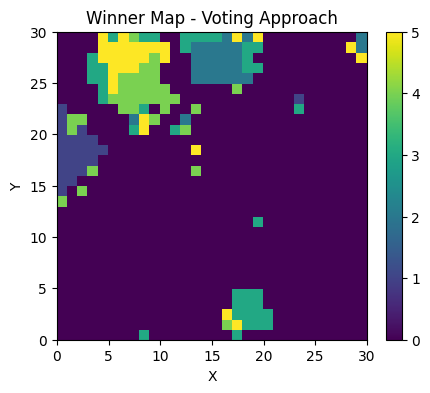

In [127]:
winner_map_voting = np.zeros((30, 30, len(np.unique(y_train))), dtype=int)
for i, x in enumerate(X_train):
    win = som_30x30.winner(x)
    winner_map_voting[win[0], win[1], y_train[i]] += 1

labels_voting = np.argmax(winner_map_voting, axis=2)
plt.figure(figsize=(5, 4))
plt.pcolor(labels_voting.T, cmap='viridis')
plt.colorbar()
plt.title('Winner Map - Voting Approach')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

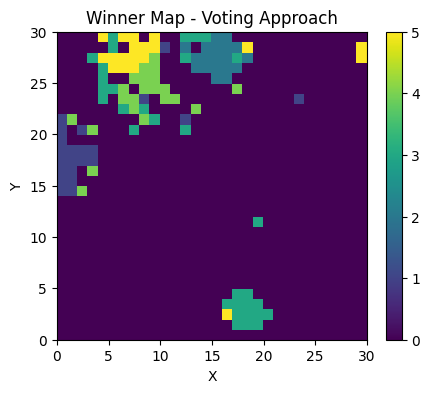

In [131]:
winner_map_voting = np.zeros((30, 30, len(np.unique(y_test))), dtype=int)
for i, x in enumerate(X_test):
    win = som_30x30.winner(x)
    winner_map_voting[win[0], win[1], y_test[i]] += 1

labels_voting = np.argmax(winner_map_voting, axis=2)
plt.figure(figsize=(5, 4))
plt.pcolor(labels_voting.T, cmap='viridis')
plt.colorbar()
plt.title('Winner Map - Voting Approach')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

AttributeError: 'collections.defaultdict' object has no attribute 'shape'

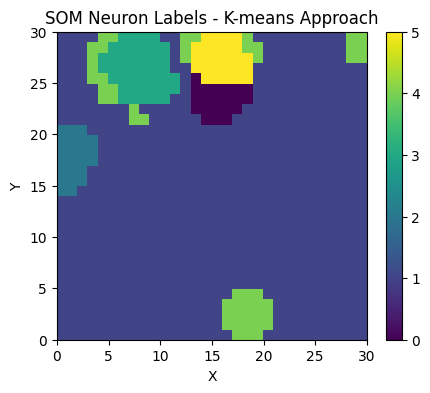

In [130]:

weights = som_30x30.get_weights()

num_neurons = weights.shape[0] * weights.shape[1]
flattened_weights = weights.reshape((num_neurons, -1))

# Step 3: Apply K-means clustering
# Use the number of unique labels in your dataset as the number of clusters
n_clusters = len(np.unique(y_train))
kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init = 10)
kmeans.fit(flattened_weights)

# Step 4: Assign labels to neurons
# The labels of the clusters are the labels for each neuron
neuron_labels = kmeans.labels_

# Reshape back to the SOM grid shape for visualization
labels_grid = neuron_labels.reshape(weights.shape[0], weights.shape[1])

# Step 5: Visualization
plt.figure(figsize=(5, 4))
plt.pcolor(labels_grid.T, cmap='viridis')  # Transposed for correct orientation
plt.colorbar()
plt.title('SOM Neuron Labels - K-means Approach')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [ ]:
from sklearn.metrics import davies_bouldin_score, normalized_mutual_info_score

# Assuming X_test is your test set and y_test are the true labels

# Step 1: Map test instances to winning neurons
winning_neurons = np.array([som_30x30.winner(x) for x in X_test])
# Convert winning neuron coordinates to indices in the flattened grid
winning_indices = winning_neurons[:, 0] * weights.shape[1] + winning_neurons[:, 1]

# Step 2: Use neuron labels for predictions
y_pred_kmeans = neuron_labels[winning_indices]

# Now, you can compare these predicted labels (y_pred_kmeans) with the true labels (y_test)
# to evaluate the clustering performance.

# Evaluation metrics
db_index_kmeans = davies_bouldin_score(y_test.reshape(-1, 1), y_pred_kmeans)
nmi_kmeans = normalized_mutual_info_score(y_test, y_pred_kmeans)

print("K-means Approach Evaluation on Test Set:")
print(f"Davies-Bouldin Index: {db_index_kmeans}")
print(f"Normalized Mutual Information: {nmi_kmeans}")
